In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import scipy.stats as stats

/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
my_data = pd.read_csv('/home/lin/教材/Financial_data/FinalTest/2015/FSE250_cleaned.csv')

In [3]:
my_data.columns

Index(['year', ' month', ' day', ' FSE250'], dtype='object')

In [4]:
my_data.head()

,year,month,day,FSE250
0,2015,3,4,17135.6
1,2015,3,3,17146.0
2,2015,3,2,17249.9
3,2015,2,27,17273.8
4,2015,2,26,17249.8


In [5]:
price = np.flip(my_data[' FSE250'], 0)

In [6]:
logR = np.log(price).diff().dropna()
logR.head(10)

6816   -0.005884
6815    0.005446
6814    0.005939
6813   -0.003664
6812    0.007662
6811    0.002512
6810   -0.003380
6809    0.004979
6808   -0.000821
6807   -0.001644
Name:  FSE250, dtype: float64

In [168]:
lr = np.log(my_data[' FSE250']).diff(-1)
lr.tail()

6813   -0.003664
6814    0.005939
6815    0.005446
6816   -0.005884
6817         NaN
Name:  FSE250, dtype: float64

In [7]:
ind_var_one = int(logR.size * (1-0.95))-1
ind_var_two = int(logR.size * (1-0.99))-1
sortedreturn = np.asarray(logR.sort_values())
Var1_1 = sortedreturn[ind_var_one]
Var2_1 = sortedreturn[ind_var_two]
print(Var1_1)
print(Var2_1)

-0.014862710956004221
-0.028797838980821666


In [93]:
def HS_var_ES(data, alpha_one, alpha_two, alpha_es):
    ind_var_one = int( data.size * (1-alpha_one))-1
    ind_var_two = int( data.size * (1-alpha_two))-1
    ind_es = int( data.size * (1-alpha_es))-1
    HS_var_ones = data[ind_var_one]
    HS_var_twos = data[ind_var_two]
    HS_ES = data[:ind_es+1].mean()
    
    print(f'Historical {alpha_one * 100}% Var is : {HS_var_ones}')
    print(f'Historical {alpha_two * 100}% Var is : {HS_var_twos}')
    print(f'Historical {alpha_es * 100}% ES is : {HS_ES}')

    return HS_var_ones, HS_var_twos, HS_ES


#In put is sorted (accending) log returns, when calculating var and ES, using floor of the index (size * alpha)

#example for sorting

#sortedreturn = np.asarray(np.sort(re20))
#sortedreturn = np.asarray(logR.sort_values())


In [94]:
HS_var_ES(sortedreturn, 0.95, 0.99, 0.975)

Historical 95.0% Var is : -0.07809135343029716
Historical 99.0% Var is : -0.12813632148758636
Historical 97.5% ES is : -0.12446116236165972


(-0.07809135343029716, -0.12813632148758636, -0.12446116236165972)

In [116]:
import scipy.integrate as integrate
def ES_normal(data, alpha_es):

    mu = np.mean(data)
    sigma = np.std(data)
    x_ticks = np.linspace(min(data), max(abs(data)),2000)
    norm_es_quantile = stats.norm.ppf(1 - alpha_es, loc = mu, scale = sigma)
    domain = x_ticks[x_ticks <= norm_es_quantile]
    pdf = stats.norm.pdf(domain, loc = mu, scale = sigma)
    to_integral = pdf * domain
    ES = integrate.trapz(to_integral, domain, dx = 0.01) / (1 - alpha_es)
    
    print(f'Assuming normal distribution, {alpha_es * 100}% ES is {ES} using numerical integration')
    CF_ES = -(sigma * stats.norm.pdf(stats.norm.ppf(alpha_es))/(1-alpha_es)- mu)
    print(f'{alpha_es * 100}% ES is {CF_ES} using closed form fomula')
    
    return ES
    
    
#data need to be a series of log return

$${\rm ES}(\Delta V_{k+1}) = V_k\sigma \frac{\phi(\Phi(\alpha))}{1-\alpha} - V_k \mu_k  $$

In [117]:
ES_normal(sortedreturn, 0.975)

Assuming normal distribution, 97.5% ES is -0.10447525621709018 using numerical integration
97.5% ES is -0.10580005994826826 using closed form fomula


-0.10447525621709018

To calculate HS var of $\alpha$, you first calculate the array size * $\alpha$ = index, since this number is not generally integer, index can be floored or capped. HS var can be difined as the index-th return in a acending sorted reture series. It can also be difined as the meam of these two.

The meanning of a x% var is that, the futrue return with the same time horizon will be equal or worse than this value with probability 1 - x%

In [8]:
tail = int(len(sortedreturn) * 0.1) + 1
body = int(len(sortedreturn) * 0.8)
left_tail = sortedreturn[: tail]
body = sortedreturn[tail : tail+body]
right_tail = sortedreturn[-tail :]

In [63]:
print(len(sortedreturn))
print(len(left_tail) + len(body) + len(right_tail))
print(left_tail[-1])
print(right_tail[0])

6817
6817
-0.009356182066598606
0.009439183899324632


In [10]:
import powerlaw
def get_alpha_and_start(data):
    fit = powerlaw.Fit(data, xmin=min(data))
    alpha_expo = fit.power_law.alpha
    fit.power_law.plot_ccdf
    fit.plot_ccdf
    return alpha_expo-1

def tail_expo_powerlaw(left_tail, right_tail):
    alphaL = get_alpha_and_start(-left_tail)
    print(f'Tail exponent for the left tail is {alphaL} based on max likelyhood estimation (using pythonpacage powerlaw)')

    alphaR = get_alpha_and_start(right_tail)
    print(f'Tail exponent for the right tail is {alphaR} based on max likelyhood estimation (using pythonpacage powerlaw)')
    
    left = pd.DataFrame(-np.flip(left_tail, 0), columns=['x'], dtype=float)
    right = pd.DataFrame(right_tail, columns=['x'], dtype=float)
    domain = np.linspace(min(left['x']), max(left['x']), 1000)

    plt.figure()
    plt.loglog(left['x'], 1 - (range(1, left.count()[0] + 1))/(left.count()[0] + 1), '+b', alpha = 0.5)
    plt.loglog(right['x'], 1 - (range(1, right.count()[0] + 1))/(right.count()[0] + 1), 'xr', alpha = 0.5)
    plt.loglog(domain, (domain*110) ** (-alphaL), '-.b')
    plt.loglog(domain, (domain*110) ** (-alphaR), '-.r')

/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


Tail exponent for the left tail is 1.8986698556906911 based on max likelyhood estimation (using pythonpacage powerlaw)
Tail exponent for the right tail is 2.2552008132588406 based on max likelyhood estimation (using pythonpacage powerlaw)


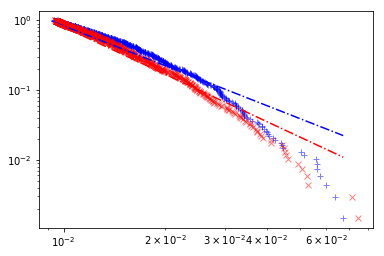

In [153]:
tail_expo_powerlaw(left_tail, right_tail)

In [11]:
get_alpha_and_start(-left_tail)

/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


1.8986698556906911

In [12]:
get_alpha_and_start(right_tail)

/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


2.2552008132588406

In [13]:
left_gen_para = stats.genpareto.fit(-left_tail)
right_gen_para = stats.genpareto.fit(right_tail)

/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2062: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2306: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


In [14]:
left_gen_para

(0.0677012736493009, 0.009356181933238374, 0.0074280469785549565)

In [15]:
right_gen_para

(0.14087333589304923, 0.00943918347962876, 0.005537415141010858)

In [43]:
left = pd.DataFrame(-np.flip(left_tail, 0), columns=['x'], dtype=float)
right = pd.DataFrame(right_tail, columns=['x'], dtype=float)

In [32]:
left.count()

x    682
dtype: int64

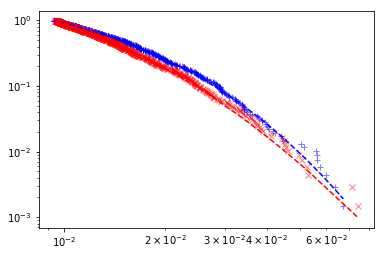

In [44]:

plt.loglog(left, 1 - (range(1, left.count()[0] + 1))/(left.count()[0] + 1), '+b', alpha = 0.5)
plt.loglog(right, 1 - (range(1, right.count()[0] + 1))/(right.count()[0] + 1), 'xr', alpha = 0.5)
plt.loglog(left, 1 - stats.genpareto.cdf(left, c=left_gen_para[0] , loc = left_gen_para[1], scale = left_gen_para[2]), '--b')
plt.loglog(right, 1 - stats.genpareto.cdf(right, c=right_gen_para[0] , loc = right_gen_para[1], scale = right_gen_para[2]), '--r')

In [45]:
(np.log(1-1/(left.count()[0]+1)) - np.log(1 - (left.count()[0])/((left.count()[0]+1))))/(np.log(left.values[0]) - np.log(left.values[-1]))

array([-3.30576442])

In [46]:
(np.log(1-1/(right.count()[0]+1))  - np.log(1 - (right.count()[0])/((right.count()[0]+1))))/(np.log(right.values[0]) - np.log(right.values[-1]))

array([-3.15593965])

In [47]:
left['y'] =  np.log(1 - (range(1, left.count()[0] + 1))/(left.count()[0] + 1))
left['newx'] = np.log(left['x'])
right['y'] = np.log(1 - (range(1, right.count()[0] + 1))/(right.count()[0] + 1))
right['newx'] = np.log(right['x'])
left.columns

Index(['x', 'y', 'newx'], dtype='object')

In [48]:
import statsmodels.formula.api as smf
resB = smf.ols(formula='y ~ newx', data=left).fit()
resB.params[1]

-2.3951104413613007

In [49]:
resB = smf.ols(formula='y ~ newx', data=right).fit()
resB.params[1]

-2.593766321769769

In [158]:
import statsmodels.formula.api as smf

def tail_expo_linRegression(left_tail, right_tail):
    left = pd.DataFrame(-np.flip(left_tail, 0), columns=['x'], dtype=float)
    right = pd.DataFrame(right_tail, columns=['x'], dtype=float)
    left['y'] =  np.log(1 - (range(1, left.count()[0] + 1))/(left.count()[0] + 1))
    left['newx'] = np.log(left['x'])
    right['y'] = np.log(1 - (range(1, right.count()[0] + 1))/(right.count()[0] + 1))
    right['newx'] = np.log(right['x'])
    resB = smf.ols(formula='y ~ newx', data=left).fit()
    alphaL = resB.params[1]
    print(f'Tail exponent for the left tail is {-alphaL} based on a linear regression')
    resB = smf.ols(formula='y ~ newx', data=right).fit()
    alphaR = resB.params[1]
    print(f'Tail exponent for the right tail is {-alphaR} based on a linear regression')

    
    domain = np.linspace(min(left['x']), max(left['x']), 1000)

    plt.figure()
    plt.loglog(left['x'], 1 - (range(1, left.count()[0] + 1))/(left.count()[0] + 1), '+b', alpha = 0.5)
    plt.loglog(right['x'], 1 - (range(1, right.count()[0] + 1))/(right.count()[0] + 1), 'xr', alpha = 0.5)
    plt.loglog(domain, (domain*100) ** (alphaL), '-.b')
    plt.loglog(domain, (domain*100) ** (alphaR), '-.r')

Tail exponent for the left tail is 2.3951104413613007 based on a linear regression
Tail exponent for the right tail is 2.593766321769769 based on a linear regression


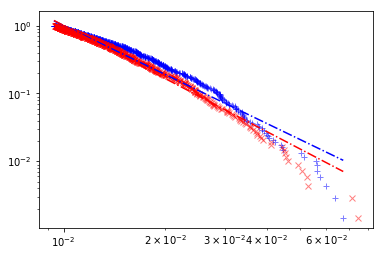

In [159]:
tail_expo_linRegression(left_tail, right_tail)

# This is not alpha, still don't know the relationship

In [95]:
print('alpha for left tail is : ')
print(1/left_gen_para[0])
print('alpha for right tail is : ')
print(1/right_gen_para[0])

alpha for left tail is : 
14.77077085994122
alpha for right tail is : 
7.098575423522291


In [44]:
import scipy.integrate as integrate

pdf = stats.genpareto.pdf(left_tail, c = left_gen_para[0] , loc = left_gen_para[1], scale = left_gen_para[2])
A = 0.1 / integrate.trapz(pdf, left_tail, dx = 0.01)
A

0.19644028411278575

In [45]:
pdf = stats.genpareto.pdf(right_tail, c = right_gen_para[0] , loc = right_gen_para[1], scale = right_gen_para[2])
B = 0.1 / integrate.trapz(pdf, right_tail, dx = 0.01)
B

0.09998634131996074

In [50]:
def function(x, x0, a):
    return -(x0/a) * (x0/x) ** a

In [161]:
A = 0.1 / (function(max(left_tail), max(left_tail), 2.3951104413613007) - function(-np.inf, max(left_tail), 2.3951104413613007))
A

25.599228663065464

In [162]:
B = 0.1 / (function(np.inf, min(right_tail), 2.2552008132588406) - function(min(right_tail), min(right_tail), 2.2552008132588406))
B

23.89190461073863

In [53]:
mu = np.mean(body)
mu

0.0005412379942985588

In [54]:
sigma = np.std(body)
sigma

0.0043988280389262455

In [55]:
body

array([-0.00935198, -0.00935145, -0.00931985, ...,  0.00941958,
        0.00943076,  0.00943241])

In [56]:
from scipy.optimize import minimize
from scipy.special import erf
cost_fun = lambda x: ((erf((mu - body[0])/(2**0.5*x)) + erf((body[-1]-mu)/(2**0.5*x))) - 1.6) **2
res = minimize(cost_fun, sigma, method = 'SLSQP')

In [57]:
res

     fun: 9.43884967350049e-08
     jac: array([0.07546487])
 message: 'Optimization terminated successfully.'
    nfev: 44
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([0.00731412])

In [58]:
res.x

array([0.00731412])

sigma is saying what I see (body) is all the possibility, but res.x is saying what I see is only 80% of the possibility

So res.x is giving a wider distribution

In [59]:
def resample(data, days=5):
    data = np.asarray(data)
    resampled = np.zeros(int(len(data)/days))
    j = days
    for i in range(len(resampled)):
        resampled[i] = sum(data[j-days:j])
        j = j + days
    return resampled

#input is daily log return series

In [60]:
re20 = resample(logR, 20)

In [95]:
ind_var_one = int(re20.size * (1-0.95))-1
ind_var_two = int(re20.size * (1-0.99))-1
sortedreturn = np.asarray(np.sort(re20))
Var1_20 = sortedreturn[ind_var_one]
Var2_20 = sortedreturn[ind_var_two]
print(Var1_20)
print(Var2_20)

-0.07809135343029716
-0.12813632148758636


In [114]:
import math
Hest1 = math.log(Var1_20/Var1_1, 20)
Hest1

0.5537957774406126

In [113]:
Hest2 = math.log(Var2_20/Var2_1, 20)
Hest2

0.49830699927981326

In [116]:
H = 0.5 * (Hest1 + Hest2)
H

0.5260513883602129

In [163]:
tail20 = int(len(re20) * 0.1)
body20 = int(len(re20) * 0.8)
left_tail20 = sortedreturn[: tail20]
body20 = sortedreturn[tail20 : tail20+body20]
right_tail20 = sortedreturn[-tail20 :]

In [164]:
print(len(sortedreturn))
print(len(left_tail20) + len(body20) + len(right_tail20))

340
340


/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


Tail exponent for the left tail is 2.456358035254785 based on max likelyhood estimation (using pythonpacage powerlaw)
Tail exponent for the right tail is 2.961122651737337 based on max likelyhood estimation (using pythonpacage powerlaw)


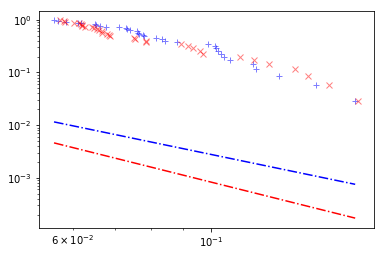

In [165]:
tail_expo_powerlaw(left_tail20, right_tail20)

Tail exponent for the left tail is 3.053438983215371 based on a linear regression
Tail exponent for the right tail is 2.7099994615799528 based on a linear regression


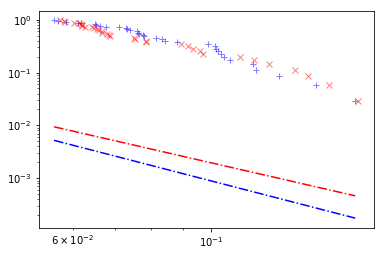

In [166]:
tail_expo_linRegression(left_tail20, right_tail20)

In [122]:
get_alpha_and_start(-left_tail20)

/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


2.456358035254785

In [123]:
get_alpha_and_start(right_tail20)

/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


2.961122651737337

In [74]:
port = pd.read_csv('/home/lin/教材/Financial_data/FinalTest/2015/portfolio_cleaned.csv')

In [75]:
port.head()

,year,month,day,RSW,OXIG,MGAM,HLMA,DNO
0,2015,3,4,2544.50,811.30,316.38,706.0,732.24
1,2015,3,3,2540.52,801.35,320.10,698.0,730.28
2,2015,3,2,2587.29,794.38,319.71,713.0,733.22
3,2015,2,27,2597.24,753.07,322.45,712.5,754.30
4,2015,2,26,2635.06,765.01,323.14,716.5,742.04


In [208]:
newPort = port[port.columns[-5:]]

In [209]:
log_r = np.log(newPort).diff(-1)
for col in log_r.columns:
    log_r[col.strip()] = log_r[col]
log_r = log_r[log_r.columns[-5 :]]
log_r.tail()

,RSW,OXIG,MGAM,HLMA,DNO
6813,0.0,0.012569,-0.003881,0.011168,0.000000
6814,0.0,0.004225,0.023513,0.000000,0.015840
6815,0.0,0.012783,0.000000,0.017508,0.009673
6816,0.0,0.000000,-0.003957,0.011494,-0.015993
6817,NaN,NaN,NaN,NaN,NaN


In [210]:
newPort.head()

,RSW,OXIG,MGAM,HLMA,DNO
0,2544.50,811.30,316.38,706.0,732.24
1,2540.52,801.35,320.10,698.0,730.28
2,2587.29,794.38,319.71,713.0,733.22
3,2597.24,753.07,322.45,712.5,754.30
4,2635.06,765.01,323.14,716.5,742.04


In [220]:
corrcoeff = log_r.corr()
corrcoeff

,RSW,OXIG,MGAM,HLMA,DNO
RSW,1.000000,0.125404,0.133100,0.257032,0.162868
OXIG,0.125404,1.000000,0.068923,0.150399,0.156349
MGAM,0.133100,0.068923,1.000000,0.141977,0.100374
HLMA,0.257032,0.150399,0.141977,1.000000,0.187714
DNO,0.162868,0.156349,0.100374,0.187714,1.000000


In [212]:
KenTau = log_r.corr(method='kendall')
KenTau

,RSW,OXIG,MGAM,HLMA,DNO
RSW,1.000000,0.098696,0.131978,0.184053,0.116964
OXIG,0.098696,1.000000,0.085888,0.093218,0.096260
MGAM,0.131978,0.085888,1.000000,0.145182,0.084082
HLMA,0.184053,0.093218,0.145182,1.000000,0.124430
DNO,0.116964,0.096260,0.084082,0.124430,1.000000


Kendall tau is non-linear correlation while Pearson is capture only linear
Kendall tau 's limitation is only capture monotonic correlation

In [213]:
KenTau = log_r.corr(method='spearman')
KenTau

,RSW,OXIG,MGAM,HLMA,DNO
RSW,1.000000,0.132469,0.186138,0.250192,0.154328
OXIG,0.132469,1.000000,0.120467,0.128501,0.128939
MGAM,0.186138,0.120467,1.000000,0.204510,0.117709
HLMA,0.250192,0.128501,0.204510,1.000000,0.168804
DNO,0.154328,0.128939,0.117709,0.168804,1.000000


In [170]:
log_r.shape

(6818, 5)

In [171]:
allAssets = newPort
allAssets['Index'] = my_data[' FSE250']

/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [214]:
allAssets.head()

,RSW,OXIG,MGAM,HLMA,DNO,Index
0,2544.50,811.30,316.38,706.0,732.24,17135.6
1,2540.52,801.35,320.10,698.0,730.28,17146.0
2,2587.29,794.38,319.71,713.0,733.22,17249.9
3,2597.24,753.07,322.45,712.5,754.30,17273.8
4,2635.06,765.01,323.14,716.5,742.04,17249.8


In [215]:
log_rAll = np.log(allAssets).diff(-1)

In [216]:
from sklearn import metrics

miMa = pd.DataFrame(index=log_rAll.columns, columns=log_rAll.columns, dtype=float)
for ref_col in log_rAll:
    for col in log_rAll:
        miMa[ref_col][col] = metrics.mutual_info_score(log_rAll[ref_col], log_rAll[col])
miMa

,RSW,OXIG,MGAM,HLMA,DNO,Index
RSW,6.175372,4.713812,5.734084,5.261274,4.500765,6.175372
OXIG,4.713812,6.179978,5.681776,5.122417,4.389145,6.179174
MGAM,5.734084,5.681776,7.883123,6.353708,5.251469,7.882319
HLMA,5.261274,5.122417,6.353708,6.900247,4.778325,6.898640
DNO,4.500765,4.389145,5.251469,4.778325,5.688799,5.686391
Index,6.175372,6.179174,7.882319,6.898640,5.686391,8.768728


In [217]:
KenTau = log_rAll.corr(method='kendall')
KenTau

,RSW,OXIG,MGAM,HLMA,DNO,Index
RSW,1.000000,0.098696,0.131978,0.184053,0.116964,0.256511
OXIG,0.098696,1.000000,0.085888,0.093218,0.096260,0.159465
MGAM,0.131978,0.085888,1.000000,0.145182,0.084082,0.253457
HLMA,0.184053,0.093218,0.145182,1.000000,0.124430,0.317071
DNO,0.116964,0.096260,0.084082,0.124430,1.000000,0.181358
Index,0.256511,0.159465,0.253457,0.317071,0.181358,1.000000


In [218]:
corrcoeff = log_rAll.corr()
corrcoeff

,RSW,OXIG,MGAM,HLMA,DNO,Index
RSW,1.000000,0.125404,0.133100,0.257032,0.162868,0.390523
OXIG,0.125404,1.000000,0.068923,0.150399,0.156349,0.209303
MGAM,0.133100,0.068923,1.000000,0.141977,0.100374,0.239998
HLMA,0.257032,0.150399,0.141977,1.000000,0.187714,0.477661
DNO,0.162868,0.156349,0.100374,0.187714,1.000000,0.252723
Index,0.390523,0.209303,0.239998,0.477661,0.252723,1.000000


In [219]:
def linRegre(data):
    betaMa = pd.DataFrame(index=data.columns, columns=data.columns)
    ssrMa = pd.DataFrame(index=data.columns, columns=data.columns)
    lenMa = pd.DataFrame(index=data.columns, columns=data.columns)
    varMa = pd.DataFrame(index=data.columns, columns=data.columns)
    for ref_col in data.columns:
        for col in data.columns:
            formu = f'{ref_col} ~ {col}'
            model = smf.ols(formula=formu, data=data)
            res = model.fit()
            betaMa[ref_col][col] = res.params[1]
            ssrMa[ref_col][col] = res.ssr
            lenMa[ref_col][col] = len(data[col].dropna())
            varMa[ref_col][col] = np.var(data[ref_col])
    return betaMa, ssrMa, lenMa, varMa

In [221]:
            
betaMa, ssrMa, lenMa, varMa = linRegre(log_r)
        
1 - ((ssrMa / lenMa) / varMa) - corrcoeff ** 2

,RSW,OXIG,MGAM,HLMA,DNO
RSW,0,3.56312e-15,1.8735e-16,1.50713e-14,1.11751e-14
OXIG,5.22846e-15,0,1.23859e-15,2.5778e-15,7.45931e-15
MGAM,8.53484e-16,-6.48787e-16,0,1.09288e-15,6.15827e-16
HLMA,1.26288e-14,1.5786e-15,2.86923e-15,0,7.11237e-15
DNO,6.95624e-15,3.35149e-15,6.07153e-17,9.99895e-15,0


In [254]:
def permutation_test(data, method='pearson', times=1000):
    
    realCorr = data.corr(method=method)
    print(realCorr)
    permuted = pd.DataFrame(columns=data.columns, dtype=float)
    counts = pd.DataFrame(np.zeros((data.shape[1], data.shape[1])), columns=data.columns, index=data.columns, dtype=float)
    minCorr = pd.DataFrame(np.ones((data.shape[1], data.shape[1])), columns=data.columns, index=data.columns, dtype=float)
    maxCorr = pd.DataFrame(np.zeros((data.shape[1], data.shape[1])), columns=data.columns, index=data.columns, dtype=float)

    for i in range(times):
        one_update = pd.DataFrame(np.zeros((data.shape[1], data.shape[1])), columns=data.columns, index=data.columns, dtype=float)

        for col in data:
            permuted[col] = data[col].sample(frac=1).reset_index(drop=True)
        ranCorr = permuted.corr(method = method)

        for col in ranCorr:
            for ref_col in ranCorr:
                if ranCorr[col][ref_col] > realCorr[col][ref_col]:
                    one_update[col][ref_col] = 1
                if ranCorr[col][ref_col] < minCorr[col][ref_col]:
                    minCorr[col][ref_col] = ranCorr[col][ref_col]
                if ranCorr[col][ref_col] > maxCorr[col][ref_col]:
                    maxCorr[col][ref_col] = ranCorr[col][ref_col]
                    
        #print(one_update)
        counts = counts + one_update
        
    return counts/times, maxCorr, minCorr

    

In [255]:
permutation_test(log_r, method='spearman')

           RSW      OXIG      MGAM      HLMA       DNO
RSW   1.000000  0.132469  0.186138  0.250192  0.154328
OXIG  0.132469  1.000000  0.120467  0.128501  0.128939
MGAM  0.186138  0.120467  1.000000  0.204510  0.117709
HLMA  0.250192  0.128501  0.204510  1.000000  0.168804
DNO   0.154328  0.128939  0.117709  0.168804  1.000000


(      RSW  OXIG  MGAM  HLMA  DNO
 RSW   0.0   0.0   0.0   0.0  0.0
 OXIG  0.0   0.0   0.0   0.0  0.0
 MGAM  0.0   0.0   0.0   0.0  0.0
 HLMA  0.0   0.0   0.0   0.0  0.0
 DNO   0.0   0.0   0.0   0.0  0.0,
            RSW      OXIG      MGAM      HLMA       DNO
 RSW   1.000000  0.044243  0.045103  0.034450  0.037413
 OXIG  0.044243  1.000000  0.033035  0.037503  0.037562
 MGAM  0.045103  0.033035  1.000000  0.045391  0.031603
 HLMA  0.034450  0.037503  0.045391  1.000000  0.044403
 DNO   0.037413  0.037562  0.031603  0.044403  1.000000,
            RSW      OXIG      MGAM      HLMA       DNO
 RSW   1.000000 -0.035964 -0.037458 -0.046428 -0.038681
 OXIG -0.035964  1.000000 -0.040921 -0.045072 -0.036792
 MGAM -0.037458 -0.040921  1.000000 -0.040534 -0.034863
 HLMA -0.046428 -0.045072 -0.040534  1.000000 -0.050770
 DNO  -0.038681 -0.036792 -0.034863 -0.050770  1.000000)

In [256]:
permutation_test(log_r.iloc[:100], method='kendall')

           RSW      OXIG      MGAM      HLMA       DNO
RSW   1.000000  0.053748  0.117600  0.237638  0.180935
OXIG  0.053748  1.000000  0.141443  0.239256  0.098268
MGAM  0.117600  0.141443  1.000000  0.227121  0.085301
HLMA  0.237638  0.239256  0.227121  1.000000  0.186169
DNO   0.180935  0.098268  0.085301  0.186169  1.000000


(        RSW   OXIG   MGAM   HLMA    DNO
 RSW   0.000  0.190  0.045  0.001  0.004
 OXIG  0.190  0.000  0.016  0.000  0.076
 MGAM  0.045  0.016  0.000  0.002  0.109
 HLMA  0.001  0.000  0.002  0.000  0.003
 DNO   0.004  0.076  0.109  0.003  0.000,
            RSW      OXIG      MGAM      HLMA       DNO
 RSW   1.000000  0.226308  0.202061  0.244514  0.207680
 OXIG  0.226308  1.000000  0.201657  0.210942  0.199575
 MGAM  0.202061  0.201657  1.000000  0.266761  0.251850
 HLMA  0.244514  0.210942  0.266761  1.000000  0.248429
 DNO   0.207680  0.199575  0.251850  0.248429  1.000000,
            RSW      OXIG      MGAM      HLMA       DNO
 RSW   1.000000 -0.243686 -0.206506 -0.230357 -0.211327
 OXIG -0.243686  1.000000 -0.261871 -0.285772 -0.231183
 MGAM -0.206506 -0.261871  1.000000 -0.210133 -0.238882
 HLMA -0.230357 -0.285772 -0.210133  1.000000 -0.212331
 DNO  -0.211327 -0.231183 -0.238882 -0.212331  1.000000)